# Analyzing Austin PD's Crime Reports Dataset

The dataset is available from the Austin Police Department on https://data.austintexas.gov/Public-Safety/Crime-Reports/fdj4-gpfu. It is updated weekly and I last downloaded the dataset on 10/6/2020.  



## Table of Contents 

    I. Introduction
    II. Data Scrubbing
    III. Exploratory Analysis 
    IV. Summary
    
    Questions:
><ul>
><li><a href="#q1"> 1. What areas of Austin have the highest crime rates?</a></li>
><li><a href="#q2"> 2. How is crime distributed in 78753?</a></li> 
><li><a href="#q3"> 3. How is crime distributed in 78741?</a></li>
><li><a href="#q4"> 4. How are violent crimes, in particular murder, capital murder, aggrivated assault, and rape distributed?
><li><a href="#q5"> 5. What significant does the family violence factor play, in violent crime, over time? 
><li><a href="#q6"> 6. How does murder appear on the map?
</a></li>

## I. Introduction

I began reviewing the Crime Reports dataset, provided by the Austin PD, around the same time I began reviewing its Hate Crimes datasets for analysis, at the beginning of 2020. This is a rather large dataset, containing over 2 million records, spanning from 2003 to the present, and is updated weekly. 

This is a self-paced project, conceived outside of both work and the educational arenas. It is my hope that this project will reveal some actionable insights that will benefit the Austin law enforcement community, news outlets, and anyone else interested in gaining knowledge on how best to combat the problem of crime in the Austin area.

I originally attempted importing the data into this notebook using Sodapy's Socrata API method but found it cumbersome. Mainly, it didn't want to work with importing the entire dataset, and added several redundant columns. I, therefore, prefer to manually download the entire dataset and re-download each week after it's updated.

In [1]:
# Importing essential libraries and configurations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
from folium import plugins
import seaborn as sns 
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 
              None)

In [2]:
# Loading the data
df = pd.read_csv('crime_reports.csv')

In [3]:
# Examining the dataframe
display(df.info())
print('----------------------------------')
display(df.duplicated().sum())
print('----------------------------------')
display(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2275255 entries, 0 to 2275254
Data columns (total 27 columns):
Incident Number                int64
Highest Offense Description    object
Highest Offense Code           int64
Family Violence                object
Occurred Date Time             object
Occurred Date                  object
Occurred Time                  float64
Report Date Time               object
Report Date                    object
Report Time                    float64
Location Type                  object
Address                        object
Zip Code                       float64
Council District               float64
APD Sector                     object
APD District                   object
PRA                            object
Census Tract                   float64
Clearance Status               object
Clearance Date                 object
UCR Category                   object
Category Description           object
X-coordinate                   float64
Y-coordin

None

----------------------------------


0

----------------------------------


Incident Number                      0
Highest Offense Description          0
Highest Offense Code                 0
Family Violence                      0
Occurred Date Time                 165
Occurred Date                        0
Occurred Time                       84
Report Date Time                     1
Report Date                          0
Report Time                          1
Location Type                    20857
Address                             12
Zip Code                         13873
Council District                 46980
APD Sector                        8803
APD District                      9273
PRA                              10512
Census Tract                   1456596
Clearance Status                603166
Clearance Date                  333955
UCR Category                   1501358
Category Description           1501358
X-coordinate                      9934
Y-coordinate                      9934
Latitude                         38381
Longitude                

## II. Data Scrubbing

There are several columns of data we won't be using in the analysis, mainly other date and geodata columns. So we'll drop those and also scrub some others. Mainly, we want the zip code and address columns to be free of nulls and duplicates. 

The Clearance Status column contains 3 types of statuses: Y for Yes, N for No, and O which stands for "cleared by other means than arrest." Therefore, I changed the column, as well as the family_violence column, to boolean type. In other words, Y and O as True, and N as False. However, you may note that areas, where there is no clearance status at all, may or may not contain a corresponding date in the clearance date column. I am unsure how best to handle this so I am open to suggestions or advice.   

In [4]:
# Helper function for scrubbing the data
def clean_data(df):
    drop_col = ['Occurred Time', 
                'Occurred Date', 
                'Report Date', 
                'Report Time', 
                'Census Tract', 
                'UCR Category', 
                'Category Description', 
                'X-coordinate', 
                'Y-coordinate', 
                'Location']
    df.drop(drop_col, 
            axis=1, 
            inplace=True)
    clean_col = ['Zip Code', 
                 'Report Date Time', 
                 'Occurred Date Time'] 
    df.dropna(subset=clean_col, 
              inplace=True)
    df.rename(columns=lambda x: x.strip().lower().replace(" ", 
                                                          "_"), 
              inplace=True)
    """Convert the following to bools"""
    d = {'Y': True, 
         'N': False}
    e = {'C': True, 
         'O': True, 
         'N': False}
    df.clearance_status = df.clearance_status.map(e)
    df.clearance_status = df.clearance_status.astype('bool')
    df.family_violence = df.family_violence.map(d)
    df.family_violence = df.family_violence.astype('bool') 
    """Convert the following to datetime type"""
    date_col = ['occurred_date_time', 
                'clearance_date', 
                'report_date_time'] 
    """Convert the following to category type"""
    cat_col = ['highest_offense_description', 
               'location_type', 
               'apd_sector'] 
    df[date_col] = df[date_col].astype('datetime64') 
    df[cat_col] = df[cat_col].astype('category') 
    """Convert the following to integer type"""
    int_col = ['zip_code']
    df['year'] = pd.to_datetime(df['occurred_date_time'], 
                                format='%m/%d/%Y').dt.year 
    df['month'] = pd.to_datetime(df['occurred_date_time'], 
                                 format='%m/%d/%Y').dt.month 
    df['hour'] = pd.to_datetime(df['occurred_date_time'], 
                                format='%m/%d/%Y').dt.hour
    df[int_col] = df[int_col].astype('int64')
    """Set the index"""
    df.set_index(['occurred_date_time'], 
                 inplace=True)
    df.sort_index(inplace=True)
    return df
df = clean_data(df)

In [5]:
# Rechecking the dataframe 
display(df.isnull().sum())
print('----------------------------------')
display(df.dtypes)
print('----------------------------------')
display(df.head())
print('----------------------------------')
display(df.tail())

incident_number                     0
highest_offense_description         0
highest_offense_code                0
family_violence                     0
report_date_time                    0
location_type                   20391
address                             0
zip_code                            0
council_district                33107
apd_sector                          8
apd_district                       11
pra                                11
clearance_status                    0
clearance_date                 330726
latitude                        27708
longitude                       27708
year                                0
month                               0
hour                                0
dtype: int64

----------------------------------


incident_number                         int64
highest_offense_description          category
highest_offense_code                    int64
family_violence                          bool
report_date_time               datetime64[ns]
location_type                        category
address                                object
zip_code                                int64
council_district                      float64
apd_sector                           category
apd_district                           object
pra                                    object
clearance_status                         bool
clearance_date                 datetime64[ns]
latitude                              float64
longitude                             float64
year                                    int64
month                                   int64
hour                                    int64
dtype: object

----------------------------------


,incident_number,highest_offense_description,highest_offense_code,family_violence,report_date_time,location_type,address,zip_code,council_district,apd_sector,apd_district,pra,clearance_status,clearance_date,latitude,longitude,year,month,hour
occurred_date_time,,,,,,,,,,,,,,,,,,,
2003-01-01,20135010506,IDENTITY THEFT,4022,False,2013-03-11 17:28:00,RESIDENCE / HOME,7001 S CONGRESS AVE,78745,2.0,FR,3,528,False,2013-03-12,30.188878,-97.780075,2003,1,0
2003-01-01,20055067732,IDENTITY THEFT,4022,False,2005-02-14 17:30:00,COMMERCIAL / OFFICE BUILDING,715 E 8TH ST,78701,9.0,GE,2,382,True,NaT,30.267553,-97.734674,2003,1,0
2003-01-01,20125033273,AGG SEXUAL ASSAULT CHILD/OBJEC,1712,False,2012-07-18 12:00:00,RESIDENCE / HOME,1100 BLOCK HARVEY ST,78702,1.0,CH,2,415,True,2013-02-27,NaN,NaN,2003,1,0
2003-01-01,20095041149,IDENTITY THEFT,4022,False,2009-07-22 11:09:00,RESIDENCE / HOME,1941 GASTON PLACE DR,78723,1.0,ID,4,295,False,2009-07-28,30.312126,-97.688964,2003,1,0
2003-01-01,20115007026,IDENTITY THEFT,4022,False,2011-02-08 15:14:00,RESIDENCE / HOME,8220 W SH 71,78735,8.0,DA,6,61,False,2011-05-23,30.246747,-97.887325,2003,1,0


----------------------------------


,incident_number,highest_offense_description,highest_offense_code,family_violence,report_date_time,location_type,address,zip_code,council_district,apd_sector,apd_district,pra,clearance_status,clearance_date,latitude,longitude,year,month,hour
occurred_date_time,,,,,,,,,,,,,,,,,,,
2020-10-10 16:30:00,20205040801,BURGLARY OF VEHICLE,601,False,2020-10-10 18:14:00,RESIDENCE / HOME,214 W WILLIAM CANNON DR,78745,2.0,FR,4,513,True,NaT,30.194629,-97.781863,2020,10,16
2020-10-10 16:38:00,20202840806,POSS/PROMO CHILD PORNOGRAPHY,2605,False,2020-10-10 16:38:00,RESIDENCE / HOME,6702 N LAMAR BLVD,78757,7.0,ID,7,277,True,NaT,30.335060,-97.721115,2020,10,16
2020-10-10 17:07:00,20205040793,IDENTITY THEFT,4022,False,2020-10-10 17:07:00,RESIDENCE / HOME,1818 SOUTH LAKESHORE BLVD,78741,9.0,HE,2,441,True,NaT,30.245289,-97.728152,2020,10,17
2020-10-10 19:23:00,20205040806,IDENTITY THEFT,4022,False,2020-10-10 19:23:00,RESIDENCE / HOME,501 E 8TH ST,78701,9.0,GE,2,382,True,NaT,30.268355,-97.737435,2020,10,19
2020-10-10 19:45:00,20205040809,VIOL OF EMERG PROTECTIVE ORDER,3008,False,2020-10-10 19:45:00,RESIDENCE / HOME,12345 ALAMEDA TRACE CIR,78727,6.0,AD,3,183,True,NaT,30.431378,-97.747069,2020,10,19


## III. Exploratory Analysis

First, let's get an overall look at crime rates and how they trend over time...

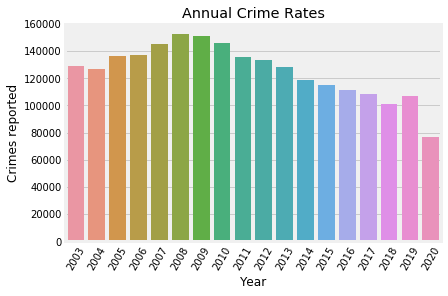

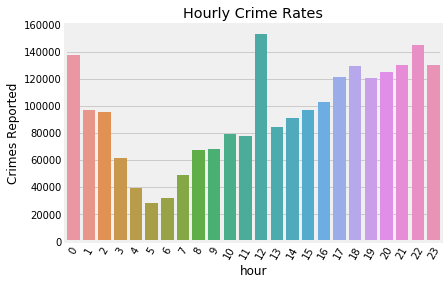

In [6]:
# Creating and visualizing a data frame for the overall yearly crime rate since 2003
crimes_per_year = df['year'].value_counts().sort_index() 

g = sns.barplot(x=crimes_per_year.index, 
                y=crimes_per_year.values)
g.set_xticklabels(g.get_xticklabels(), 
                  rotation=60)
g.set(xlabel='Year', 
      ylabel='Crimes reported', 
      title='Annual Crime Rates')
plt.show()

# Overall hourly crime rates as well
crimes_per_hour = df['hour'].value_counts().sort_index()

e = sns.barplot(x=crimes_per_hour.index, 
                y=crimes_per_hour.values)
e.set_xticklabels(e.get_xticklabels(), 
                  rotation=60)
e.set(xlabel='hour', 
      ylabel='Crimes Reported', 
      title='Hourly Crime Rates')
plt.show()

Between 2003 and now, crime peaked in 2008 and continued a downward trend until 2019 when it rose again. Since we're still in 2020, we have to wait until the end of the year to see what 2020 yields. 

<a id='q1'></a>
### A. Question 1. What areas of Austin have the highest crime rates? 

***Note: I am only including zipcodes and crimes, for questions 1 - 3, that >= 1%. Any zipcodes or crime percentages, below 1%, will be discluded to simplify analysis and visualizations.***

Question 4 regards violent crime. For violent crime, I chose to examine 4 categories: aggrivated assault, rape, murder, and capital murder. I realize there are other types of violent crime, but for now I am sticking with these 4 categories. 

78741    204678
78753    176653
78701    167113
78758    157112
78704    152961
78745    149180
78702    135755
78744    124915
78723    117054
78752     83638
78748     67186
78759     65407
78751     63394
78757     57106
78705     56381
78721     47238
78749     39963
78724     37257
78727     35420
78703     34821
78731     28269
78746     27898
78729     25303
78750     23335
78754     22400
Name: zip_code, dtype: int64

----------------------------------


78741    0.090516
78753    0.078123
78701    0.073904
78758    0.069481
78704    0.067645
78745    0.065973
78702    0.060036
78744    0.055242
78723    0.051766
78752    0.036988
78748    0.029712
78759    0.028925
78751    0.028035
78757    0.025254
78705    0.024934
78721    0.020890
78749    0.017673
78724    0.016476
78727    0.015664
78703    0.015399
78731    0.012502
78746    0.012338
78729    0.011190
78750    0.010320
78754    0.009906
Name: zip_code, dtype: float64

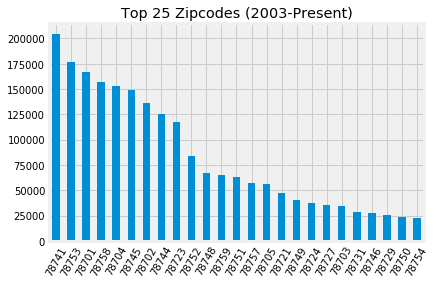

In [7]:
# Create and show dataframe for crime rates by zipcode and then as percentages
zip_codes = df.zip_code.value_counts().head(25)
display(zip_codes)
print('----------------------------------')
display(df.zip_code.value_counts(normalize=True).head(25))


# Visualizing the top 25 areas for crime 
df.zip_code.value_counts().head(25).plot.bar(rot=60, 
                                             title='Top 25 Zipcodes (2003-Present)')
plt.show()

Out of all the areas in Austin, 78741 has the highest percentage of overall crime at 9.05%. This is a significant 1.24 percentage points higher than the number 2 area 78753 which hosts 7.81% of overall crime.

#### Taking a closer look at particular areas... 

Because 78753 is my resident zipcode, I chose to examine it first. 

Next, I'll examine 78741. 

<a id='q2'></a>
### B. Question 2. How is crime distributed in 78753? 

THEFT                             16977
BURGLARY OF VEHICLE               15841
FAMILY DISTURBANCE                14406
CRIMINAL MISCHIEF                  9297
THEFT BY SHOPLIFTING               7541
ASSAULT W/INJURY-FAM/DATE VIOL     7053
BURGLARY OF RESIDENCE              6019
DWI                                4906
DISTURBANCE - OTHER                4700
CUSTODY ARREST TRAFFIC WARR        4334
HARASSMENT                         4183
AUTO THEFT                         4100
POSS OF DRUG PARAPHERNALIA         3712
PUBLIC INTOXICATION                3348
ASSAULT WITH INJURY                3256
CRIMINAL TRESPASS                  3110
POSS CONTROLLED SUB/NARCOTIC       2945
RUNAWAY CHILD                      2900
WARRANT ARREST NON TRAFFIC         2786
POSSESSION OF MARIJUANA            2686
BURGLARY NON RESIDENCE             2459
VIOL CITY ORDINANCE - OTHER        1863
Name: highest_offense_description, dtype: int64

----------------------------------


THEFT                             0.096104
BURGLARY OF VEHICLE               0.089673
FAMILY DISTURBANCE                0.081550
CRIMINAL MISCHIEF                 0.052629
THEFT BY SHOPLIFTING              0.042688
ASSAULT W/INJURY-FAM/DATE VIOL    0.039926
BURGLARY OF RESIDENCE             0.034072
DWI                               0.027772
DISTURBANCE - OTHER               0.026606
CUSTODY ARREST TRAFFIC WARR       0.024534
HARASSMENT                        0.023679
AUTO THEFT                        0.023209
POSS OF DRUG PARAPHERNALIA        0.021013
PUBLIC INTOXICATION               0.018952
ASSAULT WITH INJURY               0.018432
CRIMINAL TRESPASS                 0.017605
POSS CONTROLLED SUB/NARCOTIC      0.016671
RUNAWAY CHILD                     0.016416
WARRANT ARREST NON TRAFFIC        0.015771
POSSESSION OF MARIJUANA           0.015205
BURGLARY NON RESIDENCE            0.013920
VIOL CITY ORDINANCE - OTHER       0.010546
Name: highest_offense_description, dtype: float64

Text(0.5, 1.0, 'Crime Distribution (78753)')

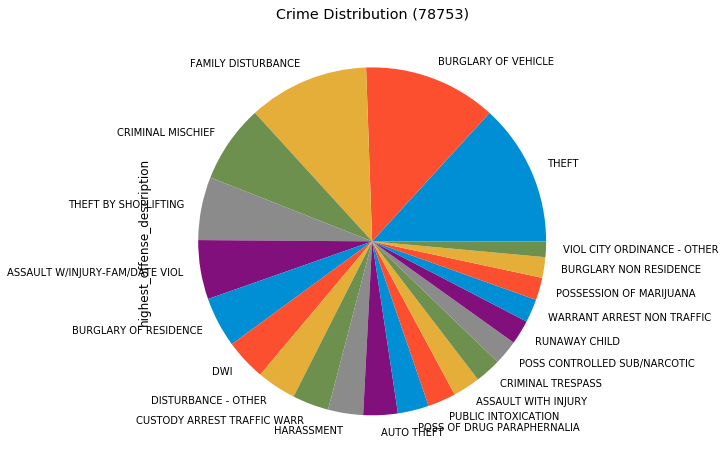

In [8]:
# Examining crime in the 78753 area
df_53 = df[df.zip_code == 78753]

# Create a dataframe for the top 10 crime categories in the zipcode
df_53_off = df_53.highest_offense_description.value_counts().head(22)

# Display the different crime values & then as percentages 
display(df_53_off)
print('----------------------------------')
display(df_53.highest_offense_description.value_counts(normalize=True).head(22))

df_53_off.plot.pie(figsize=(8,8))
plt.title('Crime Distribution (78753)')

<a id='q3'></a>
### C. Question 3. How is crime distributed in 78741? 

FAMILY DISTURBANCE                20071
BURGLARY OF VEHICLE               19704
THEFT                             15439
CRIMINAL MISCHIEF                 10929
ASSAULT W/INJURY-FAM/DATE VIOL     9560
BURGLARY OF RESIDENCE              8820
PUBLIC INTOXICATION                6362
CUSTODY ARREST TRAFFIC WARR        6011
DWI                                5616
HARASSMENT                         5440
DISTURBANCE - OTHER                5106
AUTO THEFT                         4514
ASSAULT WITH INJURY                4491
CRIMINAL TRESPASS                  3864
POSS CONTROLLED SUB/NARCOTIC       3822
POSSESSION OF MARIJUANA            3785
THEFT BY SHOPLIFTING               3558
POSS OF DRUG PARAPHERNALIA         3520
WARRANT ARREST NON TRAFFIC         3449
RUNAWAY CHILD                      2774
VIOL CITY ORDINANCE - OTHER        2195
Name: highest_offense_description, dtype: int64

----------------------------------


FAMILY DISTURBANCE                0.098061
BURGLARY OF VEHICLE               0.096268
THEFT                             0.075431
CRIMINAL MISCHIEF                 0.053396
ASSAULT W/INJURY-FAM/DATE VIOL    0.046708
BURGLARY OF RESIDENCE             0.043092
PUBLIC INTOXICATION               0.031083
CUSTODY ARREST TRAFFIC WARR       0.029368
DWI                               0.027438
HARASSMENT                        0.026578
DISTURBANCE - OTHER               0.024947
AUTO THEFT                        0.022054
ASSAULT WITH INJURY               0.021942
CRIMINAL TRESPASS                 0.018878
POSS CONTROLLED SUB/NARCOTIC      0.018673
POSSESSION OF MARIJUANA           0.018492
THEFT BY SHOPLIFTING              0.017383
POSS OF DRUG PARAPHERNALIA        0.017198
WARRANT ARREST NON TRAFFIC        0.016851
RUNAWAY CHILD                     0.013553
VIOL CITY ORDINANCE - OTHER       0.010724
Name: highest_offense_description, dtype: float64

Text(0.5, 1.0, 'Crime Distribution (78741)')

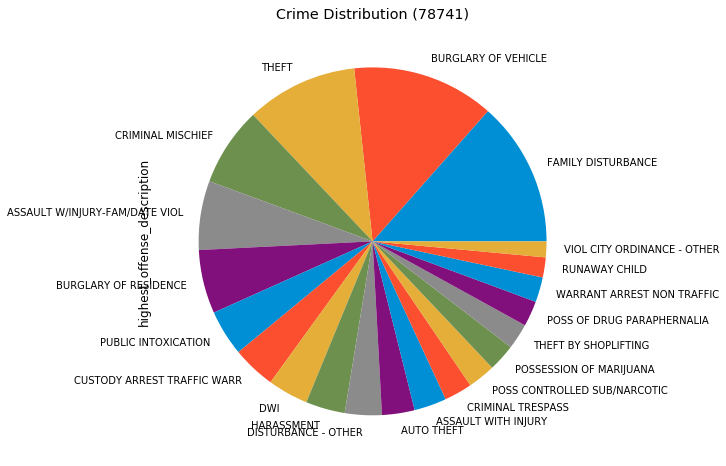

In [9]:
# Create a dataframe for crime in the 78741 area (the highest amount of crime of any Austin zip code)
df_41 = df[df.zip_code == 78741]

# Create a dataframe for the top 10 crime categories in the zipcode
df_41_off = df_41.highest_offense_description.value_counts().head(21)

# Display the different crime values & then as percentages 
display(df_41_off)
print('----------------------------------')
display(df_41.highest_offense_description.value_counts(normalize=True).head(21))

df_41_off.plot.pie(figsize=(8,8))
plt.title('Crime Distribution (78741)')

<a id='q4'></a>
### D. Question 4. How are violent crimes, in particular murder, capital murder, aggrivated assault, and rape distributed? 

***The following line of code shows crime rates only >= 1% per zipcode.***

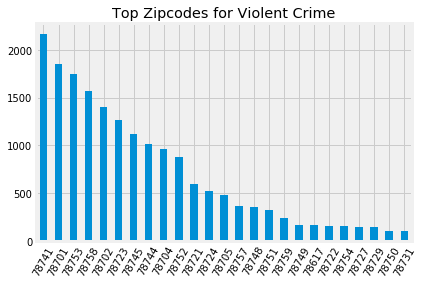

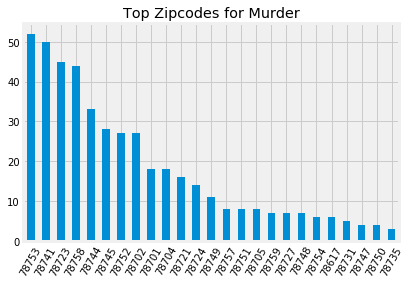

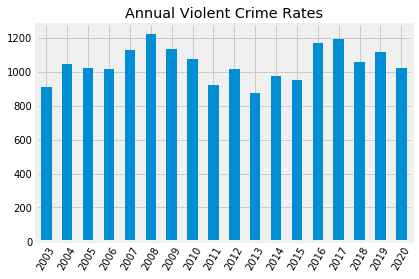

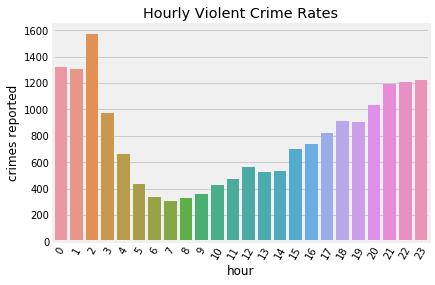

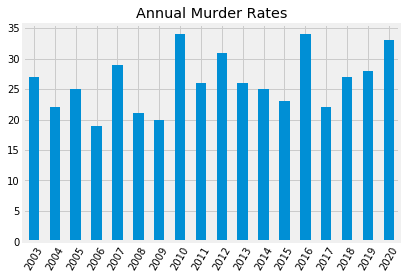

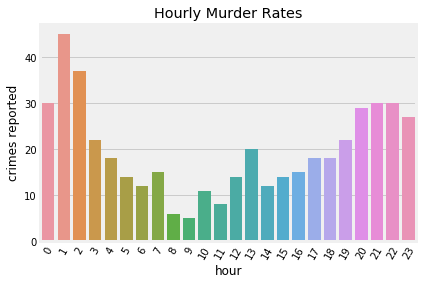

highest_offense_description,AGG ASSAULT,CAPITAL MURDER,MURDER,RAPE
zip_code,,,,
78610,1,0,0,0
78613,14,0,1,6
78617,119,0,6,36
78621,1,0,0,0
78634,1,0,0,0
78652,2,0,0,0
78653,10,0,1,1
78660,66,0,2,17
78664,3,0,0,0


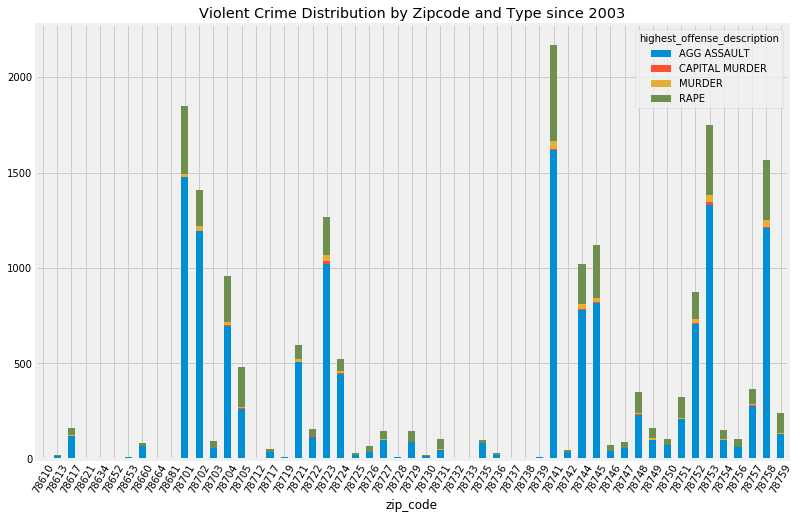

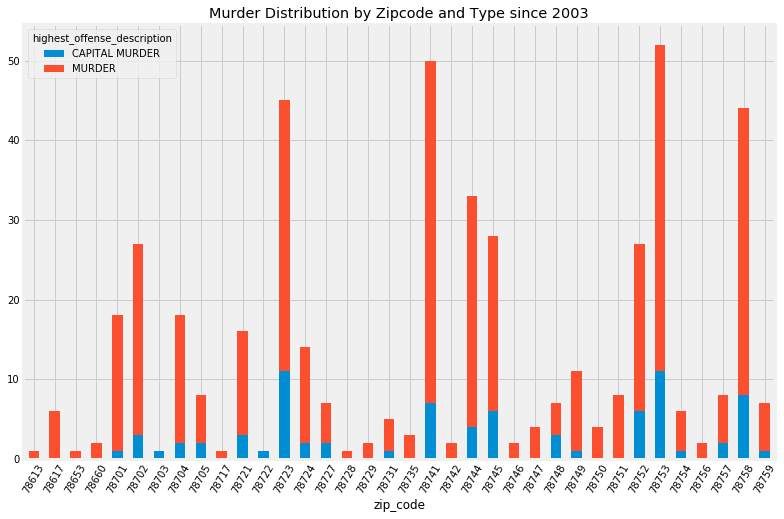

In [10]:
# Creating an overall and separate dataframes for violent crime
df_viol = df.query('highest_offense_description == ["MURDER", "CAPITAL MURDER", "RAPE", "AGG ASSAULT"]') 
df_viol_mur = df.query('highest_offense_description == ["MURDER", "CAPITAL MURDER"]')
df_mur = df[df.highest_offense_description == 'MURDER']
df_mur_cap = df[df.highest_offense_description == 'CAPITAL MURDER']
df_agg_asslt = df[df.highest_offense_description == 'AGG ASSAULT']
df_rape = df[df.highest_offense_description == 'RAPE']

#Violent Crime by Zipcode
df_viol_zip = df_viol.zip_code.value_counts().head(25)

df_viol_zip.plot.bar(title='Top Zipcodes for Violent Crime', 
                     rot=60)
plt.show()

# Murder by Zipcode
df_viol_mur.zip_code.value_counts().head(25).plot.bar(title='Top Zipcodes for Murder', 
                                                      rot=60)
plt.show()

# Visualizing violent crimes per year
viol_per_year = df_viol['year'].value_counts().sort_index()

viol_per_year.plot.bar(rot=60,
                        title='Annual Violent Crime Rates')
plt.show()

viol_by_hour = df_viol['hour'].value_counts().sort_index()

h = sns.barplot(x=viol_by_hour.index, 
                y=viol_by_hour.values)
h.set_xticklabels(h.get_xticklabels(), 
                  rotation=60)
h.set(xlabel='hour', 
      ylabel='crimes reported', 
      title='Hourly Violent Crime Rates')
plt.show()

# Visualizing murders per year
viol_mur_per_year = df_viol_mur['year'].value_counts().sort_index()

viol_mur_per_year.plot.bar(rot=60, 
                           title='Annual Murder Rates')
plt.show()
        
mur_by_hour = df_viol_mur['hour'].value_counts().sort_index()

# Visualizing hourly murder rate with Seaborn
f = sns.barplot(x=mur_by_hour.index, 
                y=mur_by_hour.values)
f.set_xticklabels(f.get_xticklabels(), 
                  rotation=60)
f.set(xlabel='hour', 
      ylabel='crimes reported', 
      title='Hourly Murder Rates')
plt.show()

# Calculating and visualizing frequency rate of violent crimes by zipcode
viol_freq = pd.crosstab(df_viol.zip_code, 
                        df_viol.highest_offense_description)

display(viol_freq)

viol_freq.plot.bar(title='Violent Crime Distribution by Zipcode and Type since 2003', 
                   stacked=True, 
                   figsize=(12,8),  
                   rot=60)
plt.show()

viol_mur_freq = pd.crosstab(df_viol_mur.zip_code, df_viol_mur.highest_offense_description)

viol_mur_freq.plot.bar(title='Murder Distribution by Zipcode and Type since 2003', 
                       stacked=True, 
                       figsize=(12,8),   
                       rot=60)
plt.show()

According to the data , 2010 and 2016 had the most number of murders . Alarmingly, this year so far has already become the 3rd most prevalent year.

<a id='q5'></a>
### E. Question 5. What significance has the family violence factor played over time? 

0.05834700583310853

----------------------------------


occurred_date_time
2003    0.039437
2004    0.045315
2005    0.049476
2006    0.054260
2007    0.058790
2008    0.058304
2009    0.055014
2010    0.052698
2011    0.060318
2012    0.061662
2013    0.057991
2014    0.057582
2015    0.062593
2016    0.066110
2017    0.067775
2018    0.074300
2019    0.070223
2020    0.075274
Name: family_violence, dtype: float64

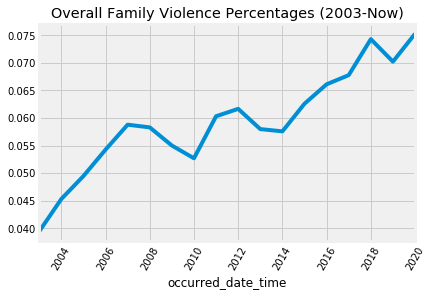

0.07825257130739052

----------------------------------


occurred_date_time
2003    0.035242
2004    0.036329
2005    0.048039
2006    0.043180
2007    0.056788
2008    0.069558
2009    0.066960
2010    0.062384
2011    0.079090
2012    0.082840
2013    0.109339
2014    0.123975
2015    0.129066
2016    0.100769
2017    0.097234
2018    0.113101
2019    0.081250
2020    0.077299
Name: family_violence, dtype: float64

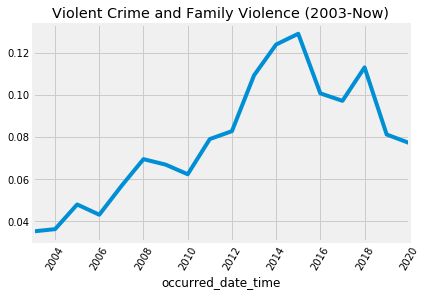

0.2055084745762712

----------------------------------


occurred_date_time
2003    0.148148
2004    0.090909
2005    0.320000
2006    0.105263
2007    0.068966
2008    0.238095
2009    0.050000
2010    0.264706
2011    0.230769
2012    0.225806
2013    0.307692
2014    0.240000
2015    0.304348
2016    0.117647
2017    0.181818
2018    0.222222
2019    0.321429
2020    0.212121
Name: family_violence, dtype: float64

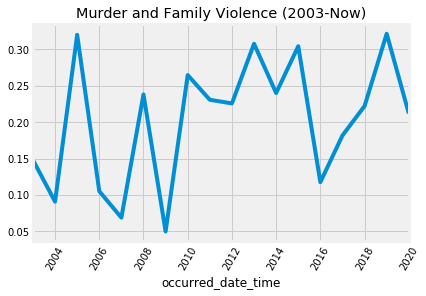

0.23093525179856114

----------------------------------


occurred_date_time
2003    0.154321
2004    0.083721
2005    0.105820
2006    0.126316
2007    0.169355
2008    0.194805
2009    0.205240
2010    0.169421
2011    0.265537
2012    0.271795
2013    0.279188
2014    0.281065
2015    0.294498
2016    0.330882
2017    0.293515
2018    0.257732
2019    0.260870
2020    0.302469
Name: family_violence, dtype: float64

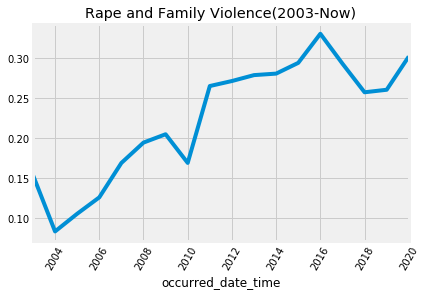

0.23093525179856114

----------------------------------


occurred_date_time
2003    0.004172
2004    0.022250
2005    0.026055
2006    0.022222
2007    0.023529
2008    0.036082
2009    0.031603
2010    0.021303
2011    0.027778
2012    0.030457
2013    0.050382
2014    0.032626
2015    0.040258
2016    0.027746
2017    0.029613
2018    0.052490
2019    0.025522
2020    0.027811
Name: family_violence, dtype: float64

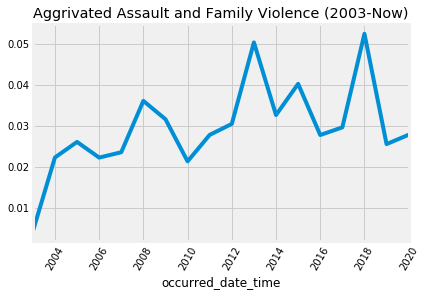

In [11]:
# Taking a look at first at the overall crime set
display(df.family_violence.mean())

print('----------------------------------')
display(df.groupby(df.index.year).family_violence.mean())

hrly_fam_viol_occurrences = df.groupby(df.index.year).family_violence.mean()

fam_viol_avg = df.groupby(df.index.year).family_violence.mean()

fam_viol_avg.plot(rot=60, 
                  title='Overall Family Violence Percentages (2003-Now)')
plt.show()

# Now taking a look at violent crime specifically 
display(df_viol.family_violence.mean())

print('----------------------------------')
display(df_viol.groupby(df_viol.index.year).family_violence.mean())

viol_hrly_fam_viol_occurrences = df_viol.groupby(df_viol.index.year).family_violence.mean()

viol_fam_viol_avg = df_viol.groupby(df_viol.index.year).family_violence.mean()

viol_fam_viol_avg.plot(rot=60, 
                       title='Violent Crime and Family Violence (2003-Now)')
plt.show()

# Now taking a look at murder with the family violence factor included 
display(df_viol_mur.family_violence.mean())

print('----------------------------------')
display(df_viol_mur.groupby(df_viol_mur.index.year).family_violence.mean())

mur_hrly_fam_viol_occurrences = df_viol_mur.groupby(df_viol_mur.index.year).family_violence.mean()

mur_fam_viol_avg = df_viol_mur.groupby(df_viol_mur.index.year).family_violence.mean()

mur_fam_viol_avg.plot(rot=60, 
                      title='Murder and Family Violence (2003-Now)')
plt.show()

# Now taking a look at rape with the family violence factor included 
display(df_rape.family_violence.mean())

print('----------------------------------')
display(df_rape.groupby(df_rape.index.year).family_violence.mean())

rape_hrly_fam_viol_occurrences = df_rape.groupby(df_rape.index.year).family_violence.mean()

rape_fam_viol_avg = df_rape.groupby(df_rape.index.year).family_violence.mean()

rape_fam_viol_avg.plot(rot=60, 
                       title='Rape and Family Violence(2003-Now)')
plt.show()

# Now taking a look at aggrivated assault with the family violence factor included 
display(df_rape.family_violence.mean())

print('----------------------------------')
display(df_agg_asslt.groupby(df_agg_asslt.index.year).family_violence.mean())

agg_asslt_fam_viol_avg = df_agg_asslt.groupby(df_agg_asslt.index.year).family_violence.mean()

agg_asslt_fam_viol_avg.plot(rot=60, 
                            title='Aggrivated Assault and Family Violence (2003-Now)')
plt.show()

Overall, family violence is seeing an upward trend as a crime factor. Violent crime saw an alarming upward trend of the family violence factor, as well. Rapes, for example, involved the family violence factor a 3rd of the time in 2016 whereas in 2004, family violence was involved less than 1% of the time. 

<a id='q6'></a>
### F. Question 6. How does murder appear on the map? 

In [12]:
# This won't work if there are NaN values in the coordinate columns
df_viol_mur.dropna(subset=['latitude', 'longitude'], 
                   inplace=True)

# Making a folium map using incident lat and lon
m = folium.Map([30.2672, -97.7431], 
               tiles='Stamen Toner', 
               zoom_level=12)

for index, row in df_viol_mur.iterrows():
	lat = row['latitude']
	lon = row['longitude']
	name= row['address']
	folium.Marker([lat, lon], 
                  popup=name).add_to(m)
    
m.save(outfile='aus_mur_map.html')

m

ED       303302
DA       291771
FR       277796
CH       271631
HE       252019
ID       248351
BA       237105
AD       206891
GE       153084
AP        10824
88         7232
UT         1048
AV          167
HENRY         1
Name: apd_sector, dtype: int64

3.0     372070
9.0     365589
4.0     334679
1.0     274685
2.0     221622
7.0     212103
5.0     170471
6.0      96162
10.0     91218
8.0      89524
Name: council_district, dtype: int64

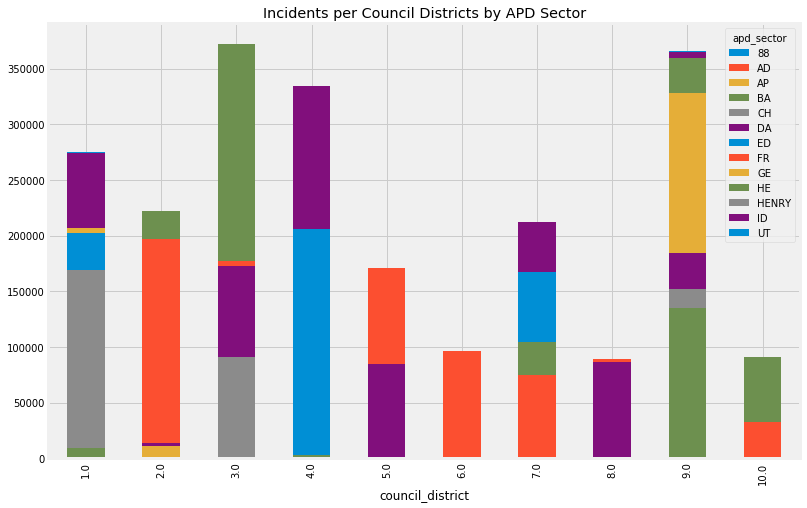

In [13]:
display(df.apd_sector.value_counts())

display(df.council_district.value_counts())

pd.crosstab(df.council_district, 
            df.apd_sector).plot.bar(stacked =True, 
                                    figsize=(12,8), 
                                    title ='Incidents per Council Districts by APD Sector')

## IV. Summary
Needless to say, violent crimes go hand-in-hand with other violent crimes.

So far, 78753 and 78741 are the top hotspots for all sorts of crime in Austin, including violent crime.

For non-capital murder, 78741 comes in at number 1 with 10.91%. 

#### ***It is important to note that murder does not necessarily make the defendant(s) automatically eligible for the death penalty. Under Texas law, we distinguish capital murder, through the motives and actions of the defendant(s) during the commission of a homicide, as whether or not automatically warranting an eventual date with the executioner. This includes such things as if the homicide was premeditated or not, if the defendant(s) murdered a police officer, etc.***

Regarding capital murder, 78723 comes in to share the number one spot with 78753, with a rate of 13.92% each. The 78741 area drops to the number 3 spot, carrying 8.97%. So, if we're honest, 78753 actually is the number 1 hotspot for murder because it has played host to 40 non-capital murders and 11 capital murders in total, meaning it has hosted 11% of all murders. 78741, if we combine all murders, only accounts for 10.56% of the total since 2003. 

Next, 78741 climbs back to claim the number 1 spot for rape at 12.09% -- 3.43 percentage points higher than the number 2 spot 78753 carrying 8.66% which is quite a significant lead when you look at it on the graph!! Why does rape occur so much more often in this area than in others?

A peculiar outlier is zipcode 78731. Although violent crime frequency ranks amongst the lowest there, rape accounts for over 50% of violent crimes committed in that area. Why is that? 

Astonishingly the family violence factor played an ever increasing role over over time, in regards to violent crime. From 2003 to 2015, family violence increased by nearly 10 percentage points--meaning you were likely to be the victim of a family member, during the commission of a rape, aggrivated assault, murder, or capital murder, only 3.15% of the time in 2003. But by 2015, that same likelihood rose to 12.82%!